Clasificación básica de texto --- 0:00 min
===

* 0:00 min | Última modificación: Marzo 7, 2022 | YouTube

Basado en:

* https://www.tensorflow.org/tutorials/keras/text_classification_with_hub

* https://www.tensorflow.org/tutorials/text/word_embeddings


Importación de librerías
---

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

tf.__version__

'2.8.0'

Análisis de sentiminetos
---

**Descarga de los datos**

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(
    "aclImdb_v1",
    url,
    untar=True,
    cache_subdir="/tmp",
)

dataset_dir = os.path.join(
    os.path.dirname(dataset),
    "aclImdb",
)

In [3]:
#
# Contenido del directorio ./aclImdb
# Note que los mensajes ya estan divididos en conjuntos
# de entrenamiento y prueba
#
!ls -1 {dataset_dir}

README
aclImdb
aclImdb_v1.tar.gz
imdb.vocab
imdbEr.txt
test
train


In [4]:
#
# Contenido del directorio de entrenamiento
#
train_dir = dataset_dir + "/train"
!ls -1 {train_dir}

labeledBow.feat
neg
pos
unsup
unsupBow.feat
urls_neg.txt
urls_pos.txt
urls_unsup.txt


In [5]:
#
# Ejemplo de un mensaje positivo
#
!cat {train_dir + "/pos/1181_9.txt"}

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.

**Carga del dataset**

```bash
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

In [6]:
#
# Remueve el directorio unsup
#
!rm -rf {train_dir + "/unsup"}

In [7]:
train_dir

'/tmp/aclImdb/train'

In [8]:
batch_size = 32
seed = 42

#
# La función text_dataset_from_directory permite leer los
# archivos de un directorio. Usa el 80% de los datos de train
# para entrenamiento y el 20% restante para validación.
# Note que la función debe llamarse dos veces.
#
# Cada mensaje es almacenado como un archivo individual y
# cada directorio representa una categoria (pos/neg)
#
# Quedan tres conjuntos de datos train, test y validation
#

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/tmp/aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
#
# raw_train_ds es una tupla conformada por la lista de
# mensajes que conforman el batch y la lista de enteros
# que codifican la clase.
#
#  (
#    [msg1, msg2, ...]
#    [lbl1, lbl2, ...]
#  )
#
# text_batch es una lista de strings (primer batch), donde
# cada string es una de las revisiones.
#
# label batch es una lista de enteros {0,1} que corresponden
# a la categoría del mensaje.
#
# Imprime los primeros tres mensajes y su etiqueta
# del primer batch
#
print()
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print()
        print("Label", label_batch.numpy()[i])
        print()


Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'

Label 0

Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get in

In [10]:
#
# Categorias
#
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [11]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/tmp/aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
#
# Lee los mensajes del grupo de testing
#
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/tmp/aclImdb/test",
    batch_size=batch_size,
)

Found 25000 files belonging to 2 classes.


**Preparación del dataset para entrenamiento**

In [13]:
def custom_standardization(input_data):

    lowercase = tf.strings.lower(input_data)

    stripped_html = tf.strings.regex_replace(
        lowercase,
        "<br />",
        " ",
    )

    return tf.strings.regex_replace(
        stripped_html,
        "[%s]" % re.escape(string.punctuation),
        "",
    )

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [15]:
#
# Requerido para TextVectorization
#
import re
import string

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [16]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [17]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [18]:
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ", vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

**Configuración del dataset para desempeño**

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Creación del modelo**

In [21]:
embedding_dim = 16

In [22]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(max_features + 1, embedding_dim),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

**Función de pérdida y optimizador**

In [23]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(
        from_logits=True,
    ),
    optimizer="adam",
    metrics=tf.metrics.BinaryAccuracy(
        threshold=0.0,
    ),
)

**Entrenamiento del modelo**

In [24]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6629 - binary_accuracy: 0.6996 - val_loss: 0.6135 - val_binary_accuracy: 0.7714
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5482 - binary_accuracy: 0.8001 - val_loss: 0.4979 - val_binary_accuracy: 0.8212
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4445 - binary_accuracy: 0.8469 - val_loss: 0.4200 - val_binary_accuracy: 0.8466
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3792 - binary_accuracy: 0.8651 - val_loss: 0.3738 - val_binary_accuracy: 0.8610
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3351 - binary_accuracy: 0.8792 - val_loss: 0.3448 - val_binary_accuracy: 0.8680
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3043 - binary_accuracy: 0.8891 - val_loss: 0.3256 - val_binary_accuracy: 0.8720
Epoch 7/10
625/625 [==============================] - 3s 5ms/ste

**Evaluación del modelo**

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 3s 3ms/step - loss: 0.3102 - binary_accuracy: 0.8732
Loss:  0.3102301061153412
Accuracy:  0.8731600046157837


**Gráfico de precisión y pérdida sobre el tiempo**

In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [28]:
acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

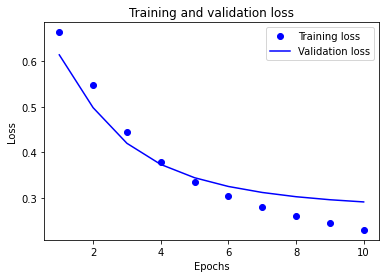

In [29]:
import matplotlib.pyplot as plt

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

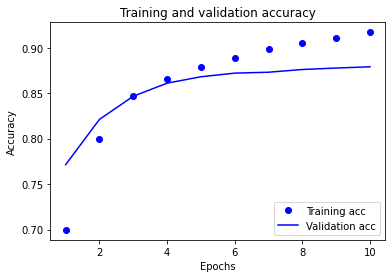

In [30]:
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.show()

Exportación del modelo
---

**Configuración del modelo**

In [31]:
export_model = tf.keras.Sequential(
    [
        vectorize_layer,
        model,
        tf.keras.layers.Activation("sigmoid"),
    ]
)

export_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"],
)

#
# Evaluación sobre el conjunto de prueba
#
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3102 - accuracy: 0.8732
0.8731600046157837


**Inferencia sobre nuevos datos**

In [32]:
examples = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible...",
]

export_model.predict(examples)

array([[0.60479915],
       [0.42614412],
       [0.34419185]], dtype=float32)